In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Resume/Miltary Data.zip' 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch import optim, cuda
from torch.utils.data import DataLoader
from tqdm import tqdm

from PIL import Image
from glob import glob
from collections import Counter,defaultdict

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

!pip install pkbar
from tqdm import tqdm
import pkbar

#Automatic mixed precision
from torch.cuda import amp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **SEED**

In [ ]:
seed=42
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  # torch.backends.cudnn.deterministic=True
  # torch.backends.cudnn.benchmark=False
else:
  torch.manual_seed(seed)
  np.random.seed(seed)

In [ ]:
# Imagenet standards
# [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [ ]:
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
        # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
traindir='/content/train'
validdir='/content/val'
testdir='/content/test'

In [ ]:
glob(traindir+'/*')

['/content/train/normal', '/content/train/camouflage']

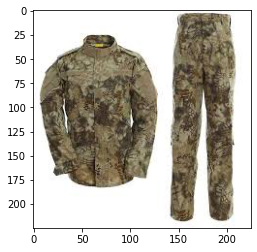

In [ ]:
img=Image.open('/content/train/camouflage/00000001.jpg')
# img=np.array(img)/255.0
plt.imshow(img)
# img.shape

## Data Visualization

In [ ]:
trans = image_transforms['train']

In [ ]:
# After applying transform our color channel is 1st place
# but we height , width, channel
trans(img).size()

torch.Size([3, 224, 224])

In [ ]:
print(f"By Using Pytorch = {trans(img).permute(1,2,0).shape}")
print(f"By Using Numpy  =  {trans(img).numpy().transpose(1,2,0).shape}")

By Using Pytorch = torch.Size([224, 224, 3])
By Using Numpy  =  (224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


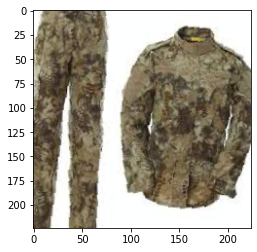

In [ ]:
img_Tras=trans(img).numpy().transpose(1,2,0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_Tras = std * img_Tras + mean
plt.imshow(img_Tras)

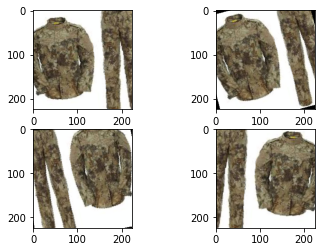

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
for i in range(4):
  ax=plt.subplot(2,2,i+1)
  img_Tras=trans(img).numpy().transpose(1,2,0)
  img_Tras = std * img_Tras + mean
  img_Tras=np.clip(img_Tras,0,1)
  plt.imshow(img_Tras)

## Data Loader

**Hyper Meters**

In [ ]:
batch_size=16
lr=1e-3

In [ ]:
data = {
    'train':datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=10),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=10)
}

In [ ]:
def get_mean_std(loader):
  channels_sum,channels_squared_sum,num_batches=0,0,0
  for data,_ in loader:
    channels_sum += torch.mean(data,dim=[0,2,3])
    channels_squared_sum += torch.mean(data**2,dim=[0,2,3])
    num_batches += 1
  mean=channels_sum/num_batches
  std=(channels_squared_sum/num_batches - mean**2)**0.5
  return mean,std

In [ ]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

## Some Stats

In [ ]:
categories = []
for d in os.listdir(traindir):
    print(d)
    categories.append(d)
    
n_classes = len(categories)
print(f'There are {n_classes} different classes.')

normal
camouflage
There are 2 different classes.


In [ ]:
data['train'].class_to_idx

{'camouflage': 0, 'normal': 1}

In [ ]:
# data['train'].targets

In [ ]:
class_to_idx = data['train'].class_to_idx
idx_to_class = {idx: class_ for class_, idx in data['train'].class_to_idx.items()}

In [ ]:
train_cnts = Counter([idx_to_class[x] for x in data['train'].targets])
val_cnts = Counter([idx_to_class[x] for x in data['valid'].targets])
test_cnts = Counter([idx_to_class[x] for x in data['test'].targets])



train_cnts = pd.DataFrame({'classes' :list(train_cnts.keys()), 'train': list(train_cnts.values())})
val_cnts = pd.DataFrame({'classes' :list(val_cnts.keys()), 'val': list(val_cnts.values())})
test_cnts = pd.DataFrame({'classes' :list(test_cnts.keys()), 'test': list(test_cnts.values())})

df = pd.merge(train_cnts,val_cnts,on='classes',how='left').merge(test_cnts,on='classes',how='left')

In [ ]:
df

,classes,train,val,test
0,camouflage,2163,242,812
1,normal,1545,169,562


## MODEL

In [ ]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# print(model)

In [ ]:
n_inputs = model.fc.in_features
n_inputs

2048

In [ ]:
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.Softmax(dim=1))

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,033,090 total parameters.
525,058 training parameters.


In [ ]:
model=model.to(device)

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
scaler=amp.GradScaler()

## Engine

In [ ]:
def train_epoch(model, data_loader,loss_fn,optimizer, device):

  model = model.train()

  n_examples=0
  losses = []
  correct_predictions = 0
  
  kbar = pkbar.Kbar(target=len(data_loader), width=10)

  for i, (images, labels) in enumerate(data_loader):

    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(images)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    n_examples += preds.size(0)

    losses.append(loss.item())
    correct_predictions += torch.sum(preds == labels)

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    # scheduler.step()
    

    accuracy= correct_predictions.double() / n_examples
    kbar.update(i, values=[("loss",loss),("Accuracy",accuracy)])

  return accuracy, np.mean(losses)

In [ ]:
# If you are using Mixed Precision on SINGLE-GPU
def train_epoch_amp(model, data_loader,loss_fn,optimizer, device,scaler):

  model = model.train()

  n_examples=0
  losses = []
  correct_predictions = 0
  
  kbar = pkbar.Kbar(target=len(data_loader), width=10)

  for i, (images, labels) in enumerate(data_loader):

    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    with amp.autocast():
      outputs = model(images)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      n_examples += preds.size(0)

      losses.append(loss.item())
      correct_predictions += torch.sum(preds == labels)

    scaler.scale(loss).backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    scaler.step(optimizer)
    scaler.update()
    # scheduler.step()
    

    accuracy= correct_predictions.double() / n_examples
    kbar.update(i, values=[("loss",loss),("Accuracy",accuracy)])

  return accuracy, np.mean(losses)

In [ ]:
def eval(loader, model,criterion,device):

    num_correct = 0
    num_samples = 0
    losses=[]
    model.eval()

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=device)
            labels = labels.to(device=device)

            output = model(images)

            loss = criterion(output, labels)
            losses.append(loss.item())


            _, predictions = torch.max(output,dim=1)
            num_correct += torch.sum(predictions == labels)
            num_samples += predictions.size(0)

            loss=np.mean(losses)
            acc=num_correct.double() / num_samples
    return acc,loss

## Training Phase

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

num_epochs=3
for epoch in range(num_epochs):

  print(f'Epoch {epoch + 1}/{num_epochs}')
  print('-' * 10)

  train_acc, train_loss = train_epoch_amp(model,dataloaders['train'],criterion,optimizer,device,scaler)

  # print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval(dataloaders['val'],model,criterion, device)

  print(f"Val_loss = {val_loss}, Val_Accuracy = {val_acc}")
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state1.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
230/232 [========>.] - ETA: 0s - loss: 0.4309 - Accuracy: 0.8356Val_loss = 0.35896256222174716, Val_Accuracy = 0.951338199513382

Epoch 2/3
----------
231/232 [========>.] - ETA: 0s - loss: 0.3966 - Accuracy: 0.9067Val_loss = 0.43669828657920545, Val_Accuracy = 0.8661800486618005

Epoch 3/3
----------
230/232 [========>.] - ETA: 0s - loss: 0.3923 - Accuracy: 0.9051Val_loss = 0.346140804199072, Val_Accuracy = 0.9635036496350365

CPU times: user 20.5 s, sys: 4.51 s, total: 25 s
Wall time: 52.6 s


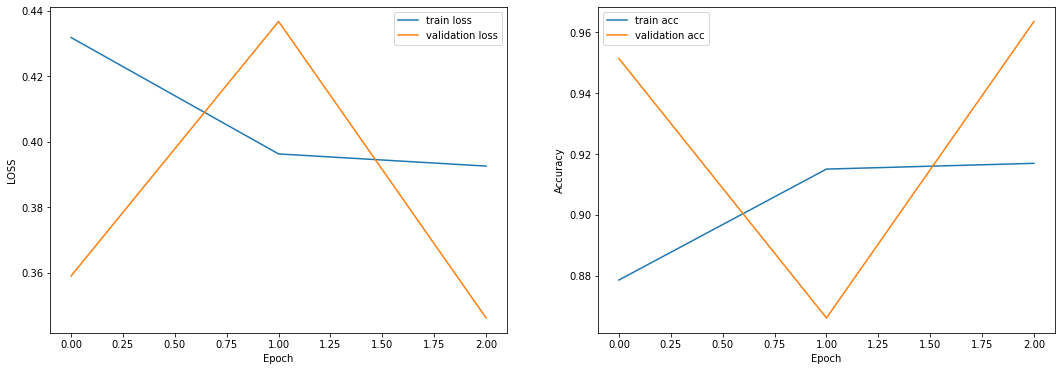

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
ax1.plot(history['train_loss'], label='train loss')
ax1.plot(history['val_loss'], label='validation loss')
ax1.set_ylabel('LOSS')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2.plot(history['train_acc'], label='train acc')
ax2.plot(history['val_acc'], label='validation acc')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()


## Predictions

In [ ]:
model_load = models.resnet50(pretrained=True)
for param in model_load.parameters():
    param.requires_grad = False

model_load.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.Softmax(dim=1))
model_load.load_state_dict(torch.load('/content/best_model_state1.bin'))
model_load.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
classes=list(data['test'].class_to_idx.keys())
classes

['camouflage', 'normal']

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = image_transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

Predicted Class is = camouflage


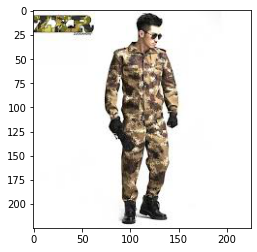

In [ ]:
PATH='/content/test/camouflage/00000003.jpg'
img=Image.open(PATH)
plt.imshow(img)
pred=predict_proba(model_load,PATH)
print(f"Predicted Class is = {classes[np.argmax(pred)]}")

In [ ]:
def show_prediction_confidence(prediction, classes):
  pred_df = pd.DataFrame({
    'class_names': classes,
    'values': pred
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

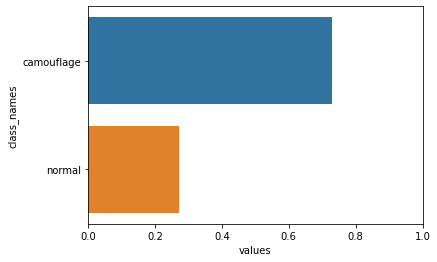

In [ ]:
show_prediction_confidence(pred, classes)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
ypred,ytest=get_predictions(model_load, dataloaders['test'])

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
print(classification_report(ypred,ytest))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       823
           1       0.93      0.95      0.94       551

    accuracy                           0.95      1374
   macro avg       0.95      0.95      0.95      1374
weighted avg       0.95      0.95      0.95      1374



In [ ]:
accuracy=accuracy_score(ypred,ytest)
print(f"Accuracy With out TTA = {accuracy}")

Accuracy With out TTA = 0.9483260553129549


## TTA

In [ ]:
tta_random_image_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])


In [ ]:
ttadata = {'test':datasets.ImageFolder(root=testdir, transform=tta_random_image_transforms)}


# Dataloader iterators
tta_dataloader = DataLoader(ttadata['test'], batch_size=512, shuffle=False,num_workers=10)

In [ ]:
print(len(tta_dataloader.dataset))
bs=tta_dataloader.batch_size
bs,n_classes

1374


(512, 2)

In [ ]:

def ttaug_mean(model, test_loader,n_times,n_classes):
  results = np.zeros((len(test_loader.dataset), n_classes))
  bs = test_loader.batch_size
  model.eval()
  with torch.no_grad():
        #aug loop:
      for _ in range(n_times):
            # Testing loop
          tmp_pred = np.zeros((len(test_loader.dataset), n_classes))
          for i,(data, targets) in enumerate(tqdm(test_loader)):
            data, targets = data.to('cuda'), targets.to('cuda')

                # Raw model output
            out = model(data)
            tmp_pred[i*bs:(i+1)*bs] = np.array(out.cpu())
            
          results+=tmp_pred
  return results/n_times

In [ ]:
pred_tta=ttaug_mean(model,tta_dataloader,n_times=5,n_classes=n_classes)






  0%|          | 0/3 [00:00<?, ?it/s]




 33%|███▎      | 1/3 [00:04<00:09,  4.83s/it]




 67%|██████▋   | 2/3 [00:05<00:03,  3.62s/it]




100%|██████████| 3/3 [00:06<00:00,  2.12s/it]





  0%|          | 0/3 [00:00<?, ?it/s]




 33%|███▎      | 1/3 [00:04<00:09,  4.95s/it]




 67%|██████▋   | 2/3 [00:05<00:03,  3.70s/it]




100%|██████████| 3/3 [00:06<00:00,  2.16s/it]





  0%|          | 0/3 [00:00<?, ?it/s]




 33%|███▎      | 1/3 [00:05<00:10,  5.08s/it]




 67%|██████▋   | 2/3 [00:05<00:03,  3.79s/it]




100%|██████████| 3/3 [00:06<00:00,  2.20s/it]





  0%|          | 0/3 [00:00<?, ?it/s]




 33%|███▎      | 1/3 [00:05<00:10,  5.10s/it]




 67%|██████▋   | 2/3 [00:05<00:03,  3.81s/it]




100%|██████████| 3/3 [00:06<00:00,  2.21s/it]





  0%|          | 0/3 [00:00<?, ?it/s]




 33%|███▎      | 1/3 [00:05<00:10,  5.17s/it]




 67%|██████▋   | 2/3 [00:05<00:03,  3.85s/it]




100%|██████████| 3/3 [00:06<00:00,  2.23s/it]


In [ ]:
pred_tta

array([[1.00000000e+00, 1.78729236e-16],
       [1.00000000e+00, 2.36114298e-23],
       [1.00000000e+00, 2.19631448e-11],
       ...,
       [1.35460134e-04, 9.99864542e-01],
       [9.61672715e-08, 9.99999905e-01],
       [1.06993758e-05, 9.99989295e-01]])

In [ ]:
pred_tta_index = np.argmax(pred_tta,axis=1)
tta_accuracy=sum(ttadata['test'].targets==pred_tta_index)/len(pred_tta_index)
print(f"TTA Accuracy: {tta_accuracy}")

TTA Accuracy: 0.9519650655021834


In [ ]:
print(f"Accuracy With out TTA = {accuracy}")
print(f"Accuracy With TTA: {tta_accuracy}")

Accuracy With out TTA = 0.9483260553129549
Accuracy With TTA: 0.9519650655021834


## Accuracy Increased by 0.003639%